In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import time
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn import preprocessing


In [2]:
dfBH = pd.read_excel('Datasets/BH_medias.xlsx')
dfIMB = pd.read_excel('Datasets/IMB_tratado.xlsx')
dfCM = pd.read_csv('Datasets/CoordenadasMunicipais.csv')

df = pd.merge(dfBH,dfCM)
df = pd.merge(df,dfIMB)

df = df[df['ESTACAO'] != 'C']
df.drop(['ESTACAO'], axis=1, inplace=True)
df = df.set_index(['MUNICIPIO'])

df['ETo_ETc'] = (df['ETo'] + df['ETc'])/2
df['Excedente_Precipitacao'] = (df['Excedente'] + df['PRECIPITACAO'])/2
df.drop(['ETo','ETc','Excedente','PRECIPITACAO'], axis=1, inplace=True)

# Move a coluna produção para a última posição
target = 'Produção'
df=df[[col for col in df.columns if col != target] + [target]]

df_teste = df[df['SAFRA']==2022]
df = df[df['SAFRA']!=2022]

# Separate the target variable and rest of the variables using .iloc to subset the data.
X, y = df.iloc[:,:-1],df.iloc[:,-1]

# Now you will convert the dataset into an optimizedto data structure called Dmatrix that XGBoost supports and gives it acclaimed performance and efficiency gains.
# You will use this later in the tutorial.
data_dmatrix = xgb.DMatrix(data=X,label=y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

# XGBoost

RMSE: 7.123878
MAE: 2.401924
MEDAE: 2.267839
MAPE: 9.354309
              modelo  teste    predito   Diff  Acuracia   MAPE
MUNICIPIO                                                     
Caiapônia    XGBoost  48.33  59.180000 -10.85     77.56  22.44
Catalão      XGBoost  66.67  61.520000   5.14     92.29   7.71
Cristalina   XGBoost  61.00  60.240002   0.76     98.75   1.25
Itumbiara    XGBoost  70.33  55.919998  14.41     79.51  20.49
Jataí        XGBoost  65.00  62.240002   2.76     95.75   4.25
Luziânia     XGBoost  68.05  59.520000   8.53     87.46  12.54
Mineiros     XGBoost  62.91  62.549999   0.36     99.43   0.57
Morrinhos    XGBoost  64.00  61.250000   2.75     95.70   4.30
Niquelândia  XGBoost  53.33  60.990002  -7.66     85.64  14.36
Paraúna      XGBoost  70.00  63.070000   6.93     90.09   9.91
Rio Verde    XGBoost  65.00  61.709999   3.29     94.93   5.07


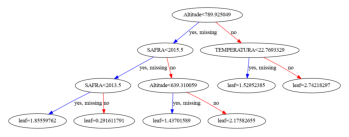

Mean:  0.3819263776417842
Standard deviation:  0.2651941067649521


In [3]:
xgb_reg = xgb.XGBRegressor(
    subsample = 0.814,
    colsample_bytree = 0.924,
    learning_rate = 0.3,
    max_depth = 5,
    min_child_weight = 8,
    reg_alpha = 0.11,
    reg_lambda = 0.738,
    gamma = 0.33,
    n_estimators = 99)

xgb_reg.fit(X_train,y_train)

X_test, y_test = df_teste.iloc[:,:-1],df_teste.iloc[:,-1]
preds = xgb_reg.predict(X_test)

Sumario = pd.DataFrame({'modelo':'XGBoost','teste':y_test,'predito':preds})
Sumario['Diff'] = Sumario['teste'] - Sumario['predito']
Sumario['Acuracia'] = (1 - abs(Sumario['Diff']/Sumario['teste']))*100
Sumario['MAPE'] = 100 - Sumario['Acuracia']

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.sqrt(mean_absolute_error(y_test, preds))
medae = np.sqrt(median_absolute_error(y_test, preds))
mape = 100-Sumario['Acuracia'].mean()

Sumario_final = pd.DataFrame([['XGBoost',rmse,mae,medae,mape]],columns=['Modelo','RMSE','MAE','MEDAE','MAPE'])

print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MEDAE: %f" % (medae))
print("MAPE: %f" % mape)

print(Sumario.round(2))

xgb.plot_tree(xgb_reg,num_trees=6)
plt.rcParams['figure.figsize'] = [10,10]
plt.show()

# Perform 5-fold cross-validation
scores = cross_val_score(xgb_reg, X, y, cv=5)
# Print the mean and standard deviation of the scores
print("Mean: ", scores.mean())
print("Standard deviation: ", scores.std())

Sumario_completo = Sumario

# Random Forest

In [4]:
rf_reg = RandomForestRegressor(
    max_features = 'auto',   
    n_estimators = 94,
    max_depth = 107,
    min_samples_split = 3,
    min_samples_leaf = 4,
    random_state = 42)

rf_reg.fit(X_train,y_train)

X_test, y_test = df_teste.iloc[:,:-1],df_teste.iloc[:,-1]
preds = rf_reg.predict(X_test)

Sumario = pd.DataFrame({'modelo':'Random Forest','teste':y_test,'predito':preds})
Sumario['Diff'] = Sumario['teste'] - Sumario['predito']
Sumario['Acuracia'] = (1 - abs(Sumario['Diff']/Sumario['teste']))*100
Sumario['MAPE'] = 100 - Sumario['Acuracia']

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.sqrt(mean_absolute_error(y_test, preds))
medae = np.sqrt(median_absolute_error(y_test, preds))
mape = 100-Sumario['Acuracia'].mean()

Sumario_final = Sumario_final.append(pd.DataFrame([['Random Forest',rmse,mae,medae,mape]],columns=['Modelo','RMSE','MAE','MEDAE','MAPE']))

print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MEDAE: %f" % (medae))
print("MAPE: %f" % mape)

print(Sumario.round(2))

# Perform 5-fold cross-validation
scores = cross_val_score(rf_reg, X, y, cv=5)

# Print the mean and standard deviation of the scores
print("Mean: ", scores.mean())
print("Standard deviation: ", scores.std())

Sumario_completo = pd.concat([Sumario_completo,Sumario])

RMSE: 7.226212
MAE: 2.504949
MEDAE: 2.464201
MAPE: 10.044310
                    modelo  teste  predito   Diff  Acuracia   MAPE
MUNICIPIO                                                         
Caiapônia    Random Forest  48.33    59.23 -10.89     77.46  22.54
Catalão      Random Forest  66.67    60.31   6.36     90.47   9.53
Cristalina   Random Forest  61.00    61.25  -0.25     99.59   0.41
Itumbiara    Random Forest  70.33    58.43  11.90     83.07  16.93
Jataí        Random Forest  65.00    59.84   5.16     92.06   7.94
Luziânia     Random Forest  68.05    61.42   6.63     90.26   9.74
Mineiros     Random Forest  62.91    60.75   2.16     96.57   3.43
Morrinhos    Random Forest  64.00    57.93   6.07     90.51   9.49
Niquelândia  Random Forest  53.33    57.97  -4.64     91.30   8.70
Paraúna      Random Forest  70.00    58.78  11.22     83.97  16.03
Rio Verde    Random Forest  65.00    61.27   3.73     94.26   5.74


/tmp/ipykernel_89180/2402587154.py:24: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Sumario_final = Sumario_final.append(pd.DataFrame([['Random Forest',rmse,mae,medae,mape]],columns=['Modelo','RMSE','MAE','MEDAE','MAPE']))


Mean:  0.407895522967131
Standard deviation:  0.09994284297233118


# Light GBM

In [5]:
lgb_reg = lgb.LGBMRegressor(
    importance_type ="split",
    subsample = 0.6,    
    colsample_bytree = 0.576,
    learning_rate = 0.045,
    max_depth = 4,
    min_child_weight = 13,
    num_leaves = 5,
    reg_alpha = 0.02,
    reg_lambda = 0.909,
    n_estimators = 99)

lgb_reg.fit(X_train,y_train)

X_test, y_test = df_teste.iloc[:,:-1],df_teste.iloc[:,-1]
preds = lgb_reg.predict(X_test)

Sumario = pd.DataFrame({'modelo':'LGBM','teste':y_test,'predito':preds})
Sumario['Diff'] = Sumario['teste'] - Sumario['predito']
Sumario['Acuracia'] = (1 - abs(Sumario['Diff']/Sumario['teste']))*100
Sumario['MAPE'] = 100 - Sumario['Acuracia']

rmse = np.sqrt(mean_squared_error(y_test, preds))
mae = np.sqrt(mean_absolute_error(y_test, preds))
medae = np.sqrt(median_absolute_error(y_test, preds))
mape = 100-Sumario['Acuracia'].mean()

Sumario_final = Sumario_final.append(pd.DataFrame([['Light GBM',rmse,mae,medae,mape]],columns=['Modelo','RMSE','MAE','MEDAE','MAPE']))

print("RMSE: %f" % (rmse))
print("MAE: %f" % (mae))
print("MEDAE: %f" % (medae))
print("MAPE: %f" % mape)

print(Sumario.round(2))

# Perform 5-fold cross-validation
scores = cross_val_score(lgb_reg, X, y, cv=5)

# Print the mean and standard deviation of the scores
print("Mean: ", scores.mean())
print("Standard deviation: ", scores.std())

Sumario_completo = pd.concat([Sumario_completo,Sumario])

RMSE: 7.972060
MAE: 2.641546
MEDAE: 2.376892
MAPE: 10.939507
            modelo  teste  predito   Diff  Acuracia   MAPE
MUNICIPIO                                                 
Caiapônia     LGBM  48.33    57.44  -9.11     81.16  18.84
Catalão       LGBM  66.67    58.39   8.28     87.58  12.42
Cristalina    LGBM  61.00    58.57   2.43     96.02   3.98
Itumbiara     LGBM  70.33    57.08  13.26     81.15  18.85
Jataí         LGBM  65.00    59.69   5.31     91.84   8.16
Luziânia      LGBM  68.05    58.59   9.46     86.11  13.89
Mineiros      LGBM  62.91    60.85   2.06     96.72   3.28
Morrinhos     LGBM  64.00    58.35   5.65     91.17   8.83
Niquelândia   LGBM  53.33    56.06  -2.73     94.89   5.11
Paraúna       LGBM  70.00    56.64  13.36     80.91  19.09
Rio Verde     LGBM  65.00    59.88   5.12     92.12   7.88
Mean:  0.3917276230270459
Standard deviation:  0.12101875048709863


/tmp/ipykernel_89180/2661078745.py:28: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  Sumario_final = Sumario_final.append(pd.DataFrame([['Light GBM',rmse,mae,medae,mape]],columns=['Modelo','RMSE','MAE','MEDAE','MAPE']))


In [6]:
Sumario_final.round(2)

,Modelo,RMSE,MAE,MEDAE,MAPE
0,XGBoost,7.12,2.40,2.27,9.35
0,Random Forest,7.23,2.50,2.46,10.04
0,Light GBM,7.97,2.64,2.38,10.94


In [7]:
Sumario_completo.round(2).sort_values(['MUNICIPIO','modelo'])

,modelo,teste,predito,Diff,Acuracia,MAPE
MUNICIPIO,,,,,,
Caiapônia,LGBM,48.33,57.44,-9.11,81.16,18.84
Caiapônia,Random Forest,48.33,59.23,-10.89,77.46,22.54
Caiapônia,XGBoost,48.33,59.18,-10.85,77.56,22.44
Catalão,LGBM,66.67,58.39,8.28,87.58,12.42
Catalão,Random Forest,66.67,60.31,6.36,90.47,9.53
Catalão,XGBoost,66.67,61.52,5.14,92.29,7.71
Cristalina,LGBM,61.00,58.57,2.43,96.02,3.98
Cristalina,Random Forest,61.00,61.25,-0.25,99.59,0.41
Cristalina,XGBoost,61.00,60.24,0.76,98.75,1.25


array([<AxesSubplot:title={'center':'LGBM'}>,
       <AxesSubplot:title={'center':'Random Forest'}>,
       <AxesSubplot:title={'center':'XGBoost'}>], dtype=object)

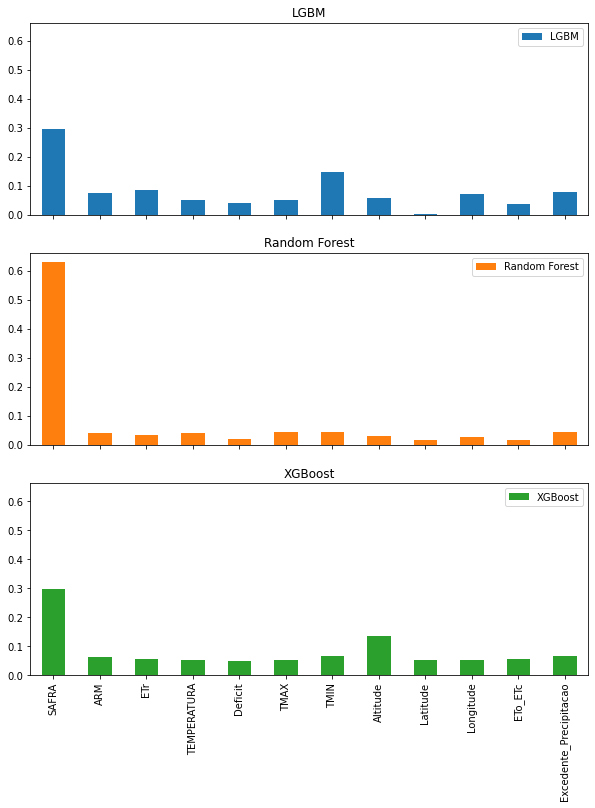

In [8]:
feature_importances_lgb = lgb_reg.feature_importances_/sum(lgb_reg.feature_importances_)
df_fi = pd.DataFrame([feature_importances_lgb,rf_reg.feature_importances_,xgb_reg.feature_importances_],columns=X_train.columns)
df_fi['modelo'] = ['LGBM', 'Random Forest','XGBoost']
df_fi.set_index(['modelo'],inplace=True)
# df_fi.stack().plot(kind="bar",subplots = True)
df_fi.T.plot(subplots = True,kind="bar",sharey=True,figsize=(10,12))

In [9]:
df_fi

,SAFRA,ARM,ETr,TEMPERATURA,Deficit,TMAX,TMIN,Altitude,Latitude,Longitude,ETo_ETc,Excedente_Precipitacao
modelo,,,,,,,,,,,,
LGBM,0.294545,0.076364,0.087273,0.050909,0.040000,0.050909,0.149091,0.058182,0.003636,0.072727,0.036364,0.080000
Random Forest,0.630537,0.040665,0.034443,0.042938,0.022156,0.046584,0.044540,0.030158,0.016120,0.027187,0.018247,0.046426
XGBoost,0.296089,0.061694,0.056445,0.052679,0.050352,0.053367,0.065872,0.136975,0.052788,0.053132,0.055731,0.064875
